![image](https://docs.google.com/uc?export=download&id=1NUy1Q-abpoV9XYK9qT9t8Mdhj3ZVlveO)


# **Taller 1**

El lenguaje de señas ha sido una herramienta que por más de 300 años ha ayudado a millones de personas a comunicarse de una manera eficaz. Actualmente, el 5% de la población mundial sufre de pérdida auditiva y la OMS estima que en el 2050, 1 de cada 10 habitantes padecerá de alguna enfermedad relacionada a problemas auditivos.

Ante la nueva ola de máquinas relacionadas al campo de la medicina, un conjunto de médicos le ha pedido realizar un modelo que les permita interpretar de manera eficiente el lenguaje de señas a través de imágenes. Esto con el fin de poder atender a sus pacientes con limitaciones de comunicación y poderles brindar un mejor servicio. Para esto, los médicos le han proporcionado un conjunto de datos donde capturaron el "gesto" de cada una de las letras del abecedario y se encargaron de etiquetarlas, excluyendo las letras como la J y la Z debido a causa del movimiento.

Para la construcción del modelo utilice los tres esquemas que se describen a continuación y compare los resultados:

1. Entrenamiento de un perceptrón multicapa.

2. Entrenamiento de un undercompleted autoencoder para realizar una reducción de la dimensionalidad. Sobre el nuevo conjunto de características construya el modelo de clasificación con un perceptrón multicapa.

3. Entrenamiento de un denoising autoendoder para preentrenar una red profunda. Reuse las primeras capas de este autoencoder para construir un perceptron multicapa (con solo el 10% de los datos).

Para los puntos b) y c) compruebe, y muestre con ejemplos, que las imágenes están bien reconstruidas.

Datos: https://www.kaggle.com/datamunge/sign-language-mnist

## Integrantes
- Carlos Santiago Oliveros
- Juan Manuel Sáenz

## Análisis del problema
Se requiere realizar distintos modelos de clasificación de imágenes, de multiples categorías (etiquetas excluyentes) correspondientes a las letras de alfabeto, con excepción de la J y la Z.

De acuerdo con la fuente de la información (https://www.kaggle.com/datasets/datamunge/sign-language-mnist), la base de datos:
- La estructuración de la BD consiste en tablas (CSV) con los valores de los pixeles de cada foto, junto con su respectiva etiqueta.
- Las etiquetas van de 0-25. Donde: A-0 y Z-25, pero para las etiquetas 9 (J) y 25 (Z) no hay imágenes.
- Los tamaños de las imágenes son de 28x28 pixeles en escala de grises con valores de 0 a 255.




## 0. Importación de librerías

In [ ]:
!pip install keras-tuner
!pip install scikeras[tensorflow]

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 135 kB 9.6 MB/s 
     |████████████████████████████████| 1.6 MB 62.7 MB/s 
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
import pandas as pd
import numpy as np
import random

import matplotlib.pyplot as plt
%matplotlib inline

import tensorflow as tf

from keras.models import Sequential
from keras.layers import Activation, Dropout, Flatten, Dense, Input, Reshape
from keras import backend as K
from keras import applications
from keras.utils.vis_utils import plot_model
from IPython.display import Image

import keras_tuner as kt
from scikeras.wrappers import KerasClassifier

from sklearn.model_selection import train_test_split, RandomizedSearchCV

from sklearn.metrics import classification_report, confusion_matrix
from sklearn.compose import make_column_selector, ColumnTransformer
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.pipeline import Pipeline, FeatureUnion

print('Tensorflow version:', tf.__version__)

Tensorflow version: 2.8.2


In [ ]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


## 1. Carga de la información

Se carga el drive donde se encuentra el json de kaggle.

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


Se crea un directorio llamado ".kaggle"

In [ ]:
!mkdir ~/.kaggle

Se copia en este directorio el json de autentificación de kaggle

In [ ]:
!cp '/content/drive/MyDrive/Colab Notebooks/kaggle.json' ~/.kaggle/

Se activa la autentificación

In [ ]:
! chmod 600 ~/.kaggle/kaggle.json

Descarga de la DB correspondiente:

In [ ]:
!kaggle datasets download -d datamunge/sign-language-mnist

 97% 61.0M/62.6M [00:00<00:00, 80.6MB/s]
100% 62.6M/62.6M [00:00<00:00, 75.0MB/s]


In [ ]:
!unzip sign-language-mnist.zip

Archive:  sign-language-mnist.zip
  inflating: amer_sign2.png          
  inflating: amer_sign3.png          
  inflating: american_sign_language.PNG  
  inflating: sign_mnist_test.csv     
  inflating: sign_mnist_test/sign_mnist_test.csv  
  inflating: sign_mnist_train.csv    
  inflating: sign_mnist_train/sign_mnist_train.csv  


El objetivo es lograr un clasificador de letras del siguiente estilo:

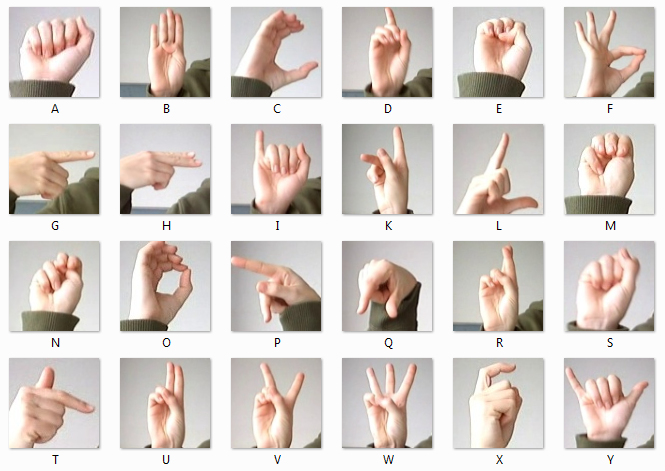

In [ ]:
Image(filename='/content/amer_sign2.png') 

Pero la información realmente viene en blanco y negro:

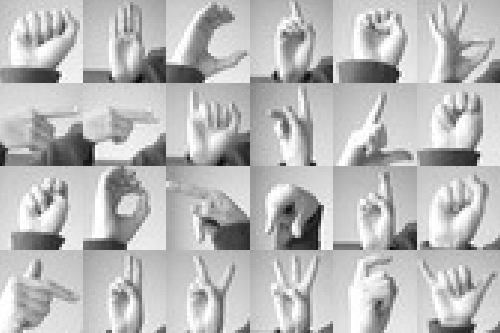

In [ ]:
Image(filename='/content/amer_sign3.png') 

Ahora, se cargan las BD de test y de entrenamiento de acuerdo con los archivos originales del repositorio.

In [ ]:
train = pd.read_csv('/content/sign_mnist_train.csv')
train.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      3     107     118     127     134     139     143     146     150   
1      6     155     157     156     156     156     157     156     158   
2      2     187     188     188     187     187     186     187     188   
3      2     211     211     212     212     211     210     211     210   
4     13     164     167     170     172     176     179     180     184   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     153  ...       207       207       207       207       206       206   
1     158  ...        69       149       128        87        94       163   
2     187  ...       202       201       200       199       198       199   
3     210  ...       235       234       233       231       230       226   
4     185  ...        92       105       105       108       133       163   

   pixel781  pixel782  pixel783  pixel784  
0       206       204       203       202  
1       175       103       135       149  
2       198       195       194       195  
3       225       222       229       163  
4       157       163       164       179  

[5 rows x 785 columns]

In [ ]:
X_train = train.drop(['label'], axis=1)
Y_train = train['label']

In [ ]:
test = pd.read_csv('/content/sign_mnist_test.csv')
test.head()

label  pixel1  pixel2  pixel3  pixel4  pixel5  pixel6  pixel7  pixel8  \
0      6     149     149     150     150     150     151     151     150   
1      5     126     128     131     132     133     134     135     135   
2     10      85      88      92      96     105     123     135     143   
3      0     203     205     207     206     207     209     210     209   
4      3     188     191     193     195     199     201     202     203   

   pixel9  ...  pixel775  pixel776  pixel777  pixel778  pixel779  pixel780  \
0     151  ...       138       148       127        89        82        96   
1     136  ...        47       104       194       183       186       184   
2     147  ...        68       166       242       227       230       227   
3     210  ...       154       248       247       248       253       236   
4     203  ...        26        40        64        48        29        46   

   pixel781  pixel782  pixel783  pixel784  
0       106       112       120       107  
1       184       184       182       180  
2       226       225       224       222  
3       230       240       253       255  
4        49        46        46        53  

[5 rows x 785 columns]

In [ ]:
X_test = test.drop(['label'], axis=1)
Y_test = test['label']

Visualización de algunas imágenes de forma aleatoria para validar la carga.

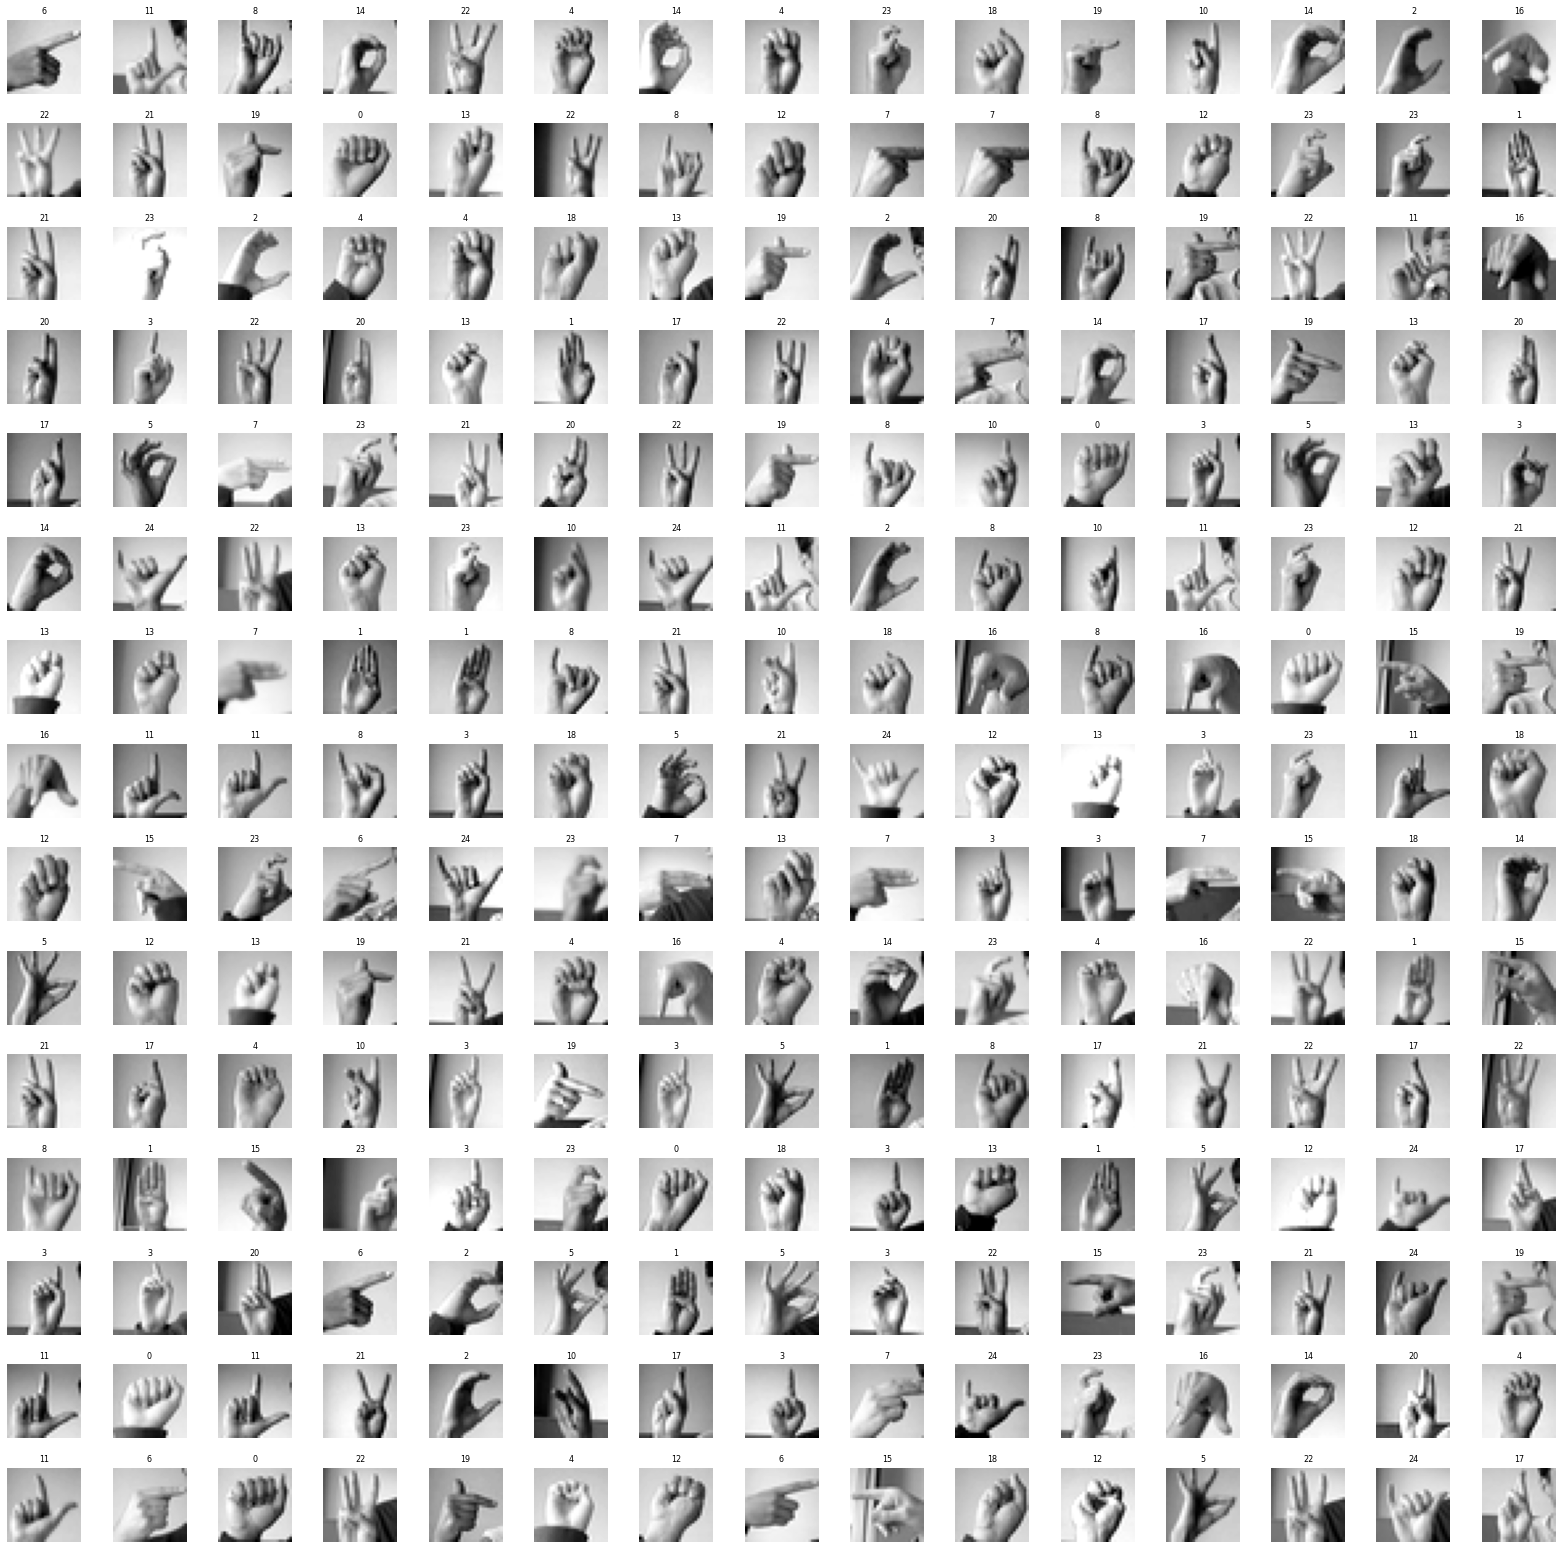

In [ ]:
W_grid = 15
L_grid = 15

fig, axes = plt.subplots(L_grid, W_grid, figsize = (28,28))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_train) # get the length of the training dataset

index_mat = np.zeros(W_grid * L_grid)

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    index_mat[i] = index
    axes[i].imshow( X_train.iloc[index].values.reshape(28,28), cmap='gray')
    axes[i].set_title(Y_train.iloc[index], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Se crea además del grupo de test, un grupo de validación.

In [ ]:
X_Train, X_Val, Y_Train, Y_Val = train_test_split(X_train, Y_train, test_size=0.2, random_state=33)

## 2. Preparación de los datos
Independientemente del modelo final utilizado, se pueden realizar algunas acciones generales de preparación  de los datos.
- Los datos se normalizan a escala 0-1 de modo que se ajusten mejor dentro del rango de las funciones de activación de las neuronas.

In [ ]:
X_Train = X_Train / 255
X_test = X_test / 255
X_Val = X_Val / 255

Se re-clasifican las categorías dado que no hay 2 tipos de etiquetas.

In [ ]:
display(Y_Train.head())
label_encoder = LabelEncoder()
Y_Train= label_encoder.fit_transform(Y_Train)
Y_test= label_encoder.transform(Y_test)
Y_Val= label_encoder.transform(Y_Val)


25906    17
8678      0
3784     17
24628    15
10141    13
Name: label, dtype: int64

In [ ]:
Y_train= label_encoder.transform(Y_train)

Ahora se comparan las mismas imágenes anteriores con la nueva etiqueta:

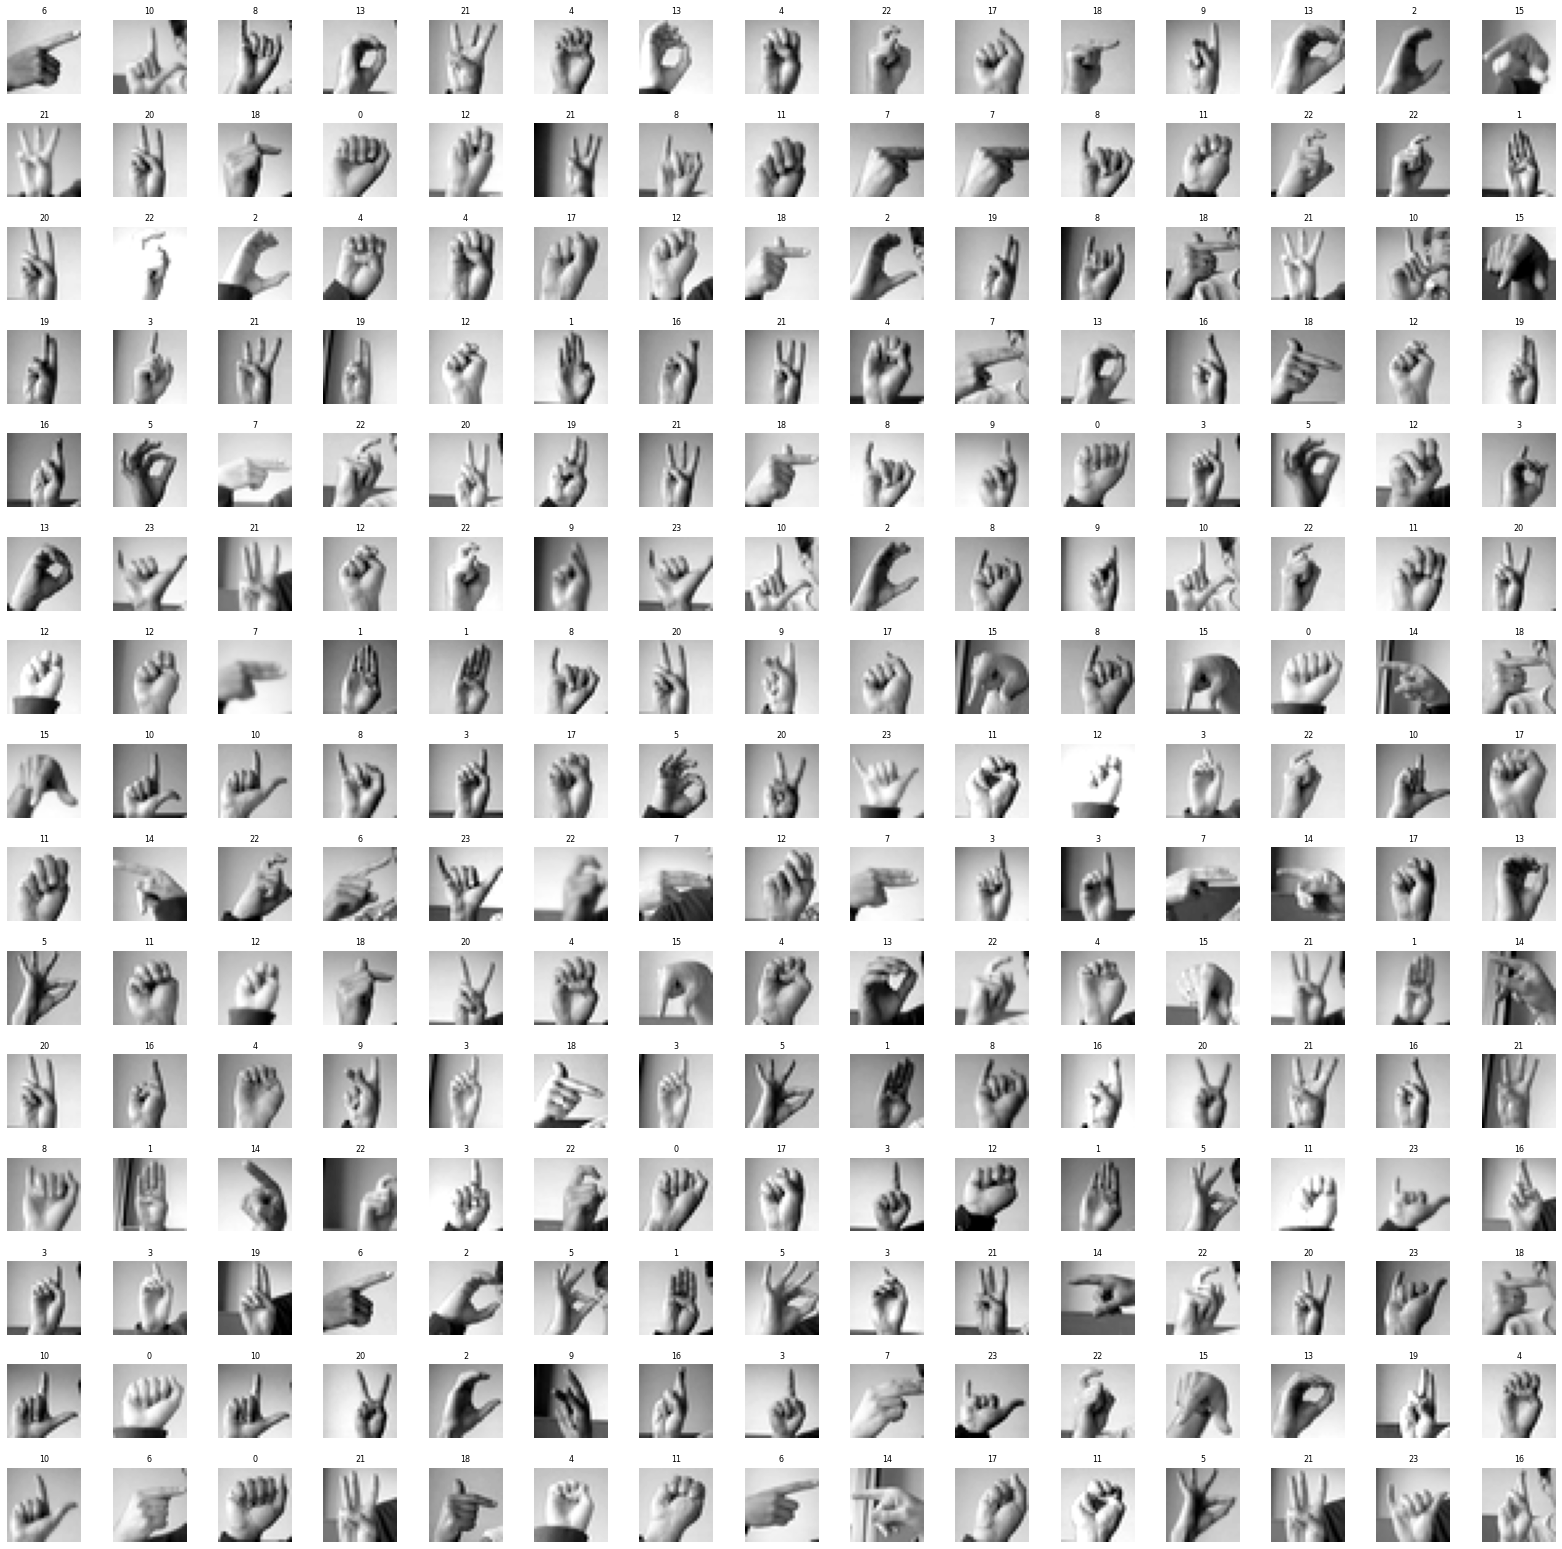

In [ ]:
fig, axes = plt.subplots(L_grid, W_grid, figsize = (28,28))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = index_mat[i]
    axes[i].imshow( X_train.iloc[int(index)].values.reshape(28,28), cmap='gray')
    axes[i].set_title(Y_train[int(index)], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Resumen de conversión:

In [ ]:
ClassLetters=['A','B','C','D','E','F','G','H','I','K','L','M','N','O','P','Q','R','S','T','U','V','W','X','Y']
NormalID=[0,1,2,3,4,5,6,7,8,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24]
ConversionID=label_encoder.transform(NormalID)

display(ConversionID)

array([ 0,  1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16,
       17, 18, 19, 20, 21, 22, 23])

En resumen, se corren las unidades 1 o 2 referencias en orden dado que la BD está ordenada por letras.

Para los siguientes modelos, todos aquellos que lleven la tarea de CLASIFICACIÓN se optimizarán para mejorar especialmente su ACCURACY. Se quiere que la traducción sea lo más acertado posible, con el menor número de errores posibles (FN, FP).

## 3. PERCEPTRON MULTICAPA
Para empezar, se plantea hacer la clasificación con un perceptron multicapa.
Primero, se realiza un primer ejercicio arbitrario de referencia, antes de realizas la búsqueda de hiperparámetros.

Algunos criterios para la definición de esta red neuronal:
- De forma convencional se selecciona para las neuronas de las capas ocultas una función de activación ReLu.
- Dado que se trata de una tarea de clasificación multiclase se utiliza para la capa de salida una función de activación sigmoide.
- Dado que se trata de una tarea de clasificación multiclase se usa como error la Entropía Cruzada.

In [ ]:
clf_PPMC0 = Sequential(name='Clasif_PMC0')

#Capa de Entrada
clf_PPMC0.add(Input(shape=(X_Train.shape[1]), name='Input_Layer'))

#Capas Ocultas
clf_PPMC0.add(Dense(50, activation='relu', name='Capa_Oculta1_Clasificador'))

#Capa de Salida
clf_PPMC0.add(Dense(len(label_encoder.classes_), activation='softmax', name='Capa_Clasificador'))

clf_PPMC0.compile(loss='sparse_categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
clf_PPMC0.summary()

Model: "Clasif_PMC0"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta1_Clasificador (  (None, 50)               39250     
 Dense)                                                          
                                                                 
 Capa_Clasificador (Dense)   (None, 24)                1224      
                                                                 
Total params: 40,474
Trainable params: 40,474
Non-trainable params: 0
_________________________________________________________________


Se entrena esta primer red de referencia:

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

In [ ]:
clf_PPMC0.fit(X_Train, Y_Train, 
                epochs=10, 
                batch_size=200, 
                callbacks=my_callbacks,
                validation_data=( X_Val, Y_Val )
                )

Epoch 1/10
110/110 [==============================] - 5s 8ms/step - loss: 2.9158 - accuracy: 0.1607 - val_loss: 2.5924 - val_accuracy: 0.2714
Epoch 2/10
110/110 [==============================] - 1s 7ms/step - loss: 2.3213 - accuracy: 0.3388 - val_loss: 2.1272 - val_accuracy: 0.3569
Epoch 3/10
110/110 [==============================] - 1s 7ms/step - loss: 1.9467 - accuracy: 0.4460 - val_loss: 1.8121 - val_accuracy: 0.4883
Epoch 4/10
110/110 [==============================] - 1s 6ms/step - loss: 1.7125 - accuracy: 0.5217 - val_loss: 1.6089 - val_accuracy: 0.5494
Epoch 5/10
110/110 [==============================] - 1s 7ms/step - loss: 1.5446 - accuracy: 0.5713 - val_loss: 1.4635 - val_accuracy: 0.5833
Epoch 6/10
110/110 [==============================] - 1s 6ms/step - loss: 1.4158 - accuracy: 0.5993 - val_loss: 1.3416 - val_accuracy: 0.6183
Epoch 7/10
110/110 [==============================] - 1s 6ms/step - loss: 1.3147 - accuracy: 0.6297 - val_loss: 1.2512 - val_accuracy: 0.6471
Epoch 

Algunas métricas del rendimiento:

In [ ]:
y_pred = np.argmax(clf_PPMC0.predict(X_test), axis=1)

print(classification_report(y_true=Y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.84      0.81      0.83       331
           1       0.75      0.75      0.75       432
           2       0.87      0.73      0.79       310
           3       0.54      0.67      0.60       245
           4       0.80      0.81      0.81       498
           5       0.70      0.75      0.73       247
           6       0.72      0.64      0.67       348
           7       0.90      0.64      0.75       436
           8       0.56      0.44      0.49       288
           9       0.57      0.44      0.50       331
          10       0.67      1.00      0.80       209
          11       0.44      0.38      0.41       394
          12       0.43      0.50      0.47       291
          13       0.54      0.59      0.56       246
          14       0.88      0.96      0.92       347
          15       0.50      0.76      0.60       164
          16       0.23      0.57      0.33       144
          17       0.17    

Se plantean, además, la revisión de otras alternativas buscándo hiperparámetros.

Como hiperparámetros de búsqueda se tienen:
- Número de neuronas.
- Número de capas.
- Optimizador.
- Como se está usando la variable de clases como una única clase categórica se usa como pérdida SPARSE CATEGORICAL CROSSENTROPY de acuerdo con la documentación de Keras (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
- Dada la naturaleza del problema, no se optimiza la clase de salida: se define softmax por ser un problema multiclase.

In [ ]:
def entrenarRed(hp):
    clf_PPMC = Sequential(name='Red_Best_PPMC')
    output = len(label_encoder.classes_)
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[100, 50, 20]','[50, 30, 20]','[150, 80, 30]'])
    optimizer_MLP = hp.Choice('Optimizer_MLP',['adam','sgd'])
        
    neuronas_MLP = eval(neuronas_MLP)

    # Neurona de entrada
    clf_PPMC.add(Input(shape=(X_Train.shape[1]),batch_size=None,name='Input_Layer'))
    
    # Neuronas ocultas
    for i in range(n_layers_MLP):
        clf_PPMC.add(Dense(neuronas_MLP[i], activation='relu', name='Capa_Oculta_{0}'.format(i)))

    # Capa de salida
    clf_PPMC.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf_PPMC.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_MLP,
                metrics=['accuracy'])
    return clf_PPMC

tuner = kt.RandomSearch(
    entrenarRed,
    objective="val_accuracy",
    seed=123,
    max_trials=10)

In [ ]:
# device_name = tf.test.gpu_device_name()
# if device_name != '/device:GPU:0':
#   raise SystemError('GPU device not found')
# print('Found GPU at: {}'.format(device_name))

In [ ]:
tuner.search(X_Train, Y_Train, 
             validation_data=(X_Val, Y_Val),
             callbacks=my_callbacks,
             epochs=30)

Trial 10 Complete [00h 01m 13s]
val_accuracy: 0.994718611240387

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 09m 51s


In [ ]:
# with tf.device('/device:GPU:0'): 
#     tuner.search(X_Train, Y_Train, 
#              validation_data=(X_Val, Y_Val),
#              project_name="flower_detection",
#              callbacks=my_callbacks,
#              epochs=30)
    
# best_model = tuner.get_best_models()[0]

In [ ]:
best_model = tuner.get_best_models()[0]
best_model.save('best_model_MPPC.h5')
best_model.summary()

Model: "Red_Best_PPMC"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Oculta_0 (Dense)       (None, 150)               117750    
                                                                 
 Capa_Oculta_1 (Dense)       (None, 80)                12080     
                                                                 
 Capa_Oculta_2 (Dense)       (None, 30)                2430      
                                                                 
 Capa_Respuesta (Dense)      (None, 24)                744       
                                                                 
Total params: 133,004
Trainable params: 133,004
Non-trainable params: 0
_________________________________________________________________


Se compara el rendimiento con respecto al modelo anterior

In [ ]:
best_MLP = best_model
y_pred = np.argmax(best_MLP.predict(X_test), axis=1)

print(classification_report(y_true=Y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       331
           1       1.00      0.91      0.95       432
           2       0.79      0.93      0.86       310
           3       0.77      0.91      0.83       245
           4       0.86      0.92      0.89       498
           5       0.75      0.91      0.82       247
           6       0.77      0.67      0.72       348
           7       0.91      0.95      0.93       436
           8       0.80      0.87      0.84       288
           9       0.63      0.66      0.64       331
          10       0.87      0.85      0.86       209
          11       0.63      0.54      0.58       394
          12       0.66      0.38      0.48       291
          13       0.99      0.61      0.75       246
          14       0.91      0.88      0.90       347
          15       0.80      0.91      0.85       164
          16       0.35      0.57      0.44       144
          17       0.40    

Se visualizan algunos resultados:

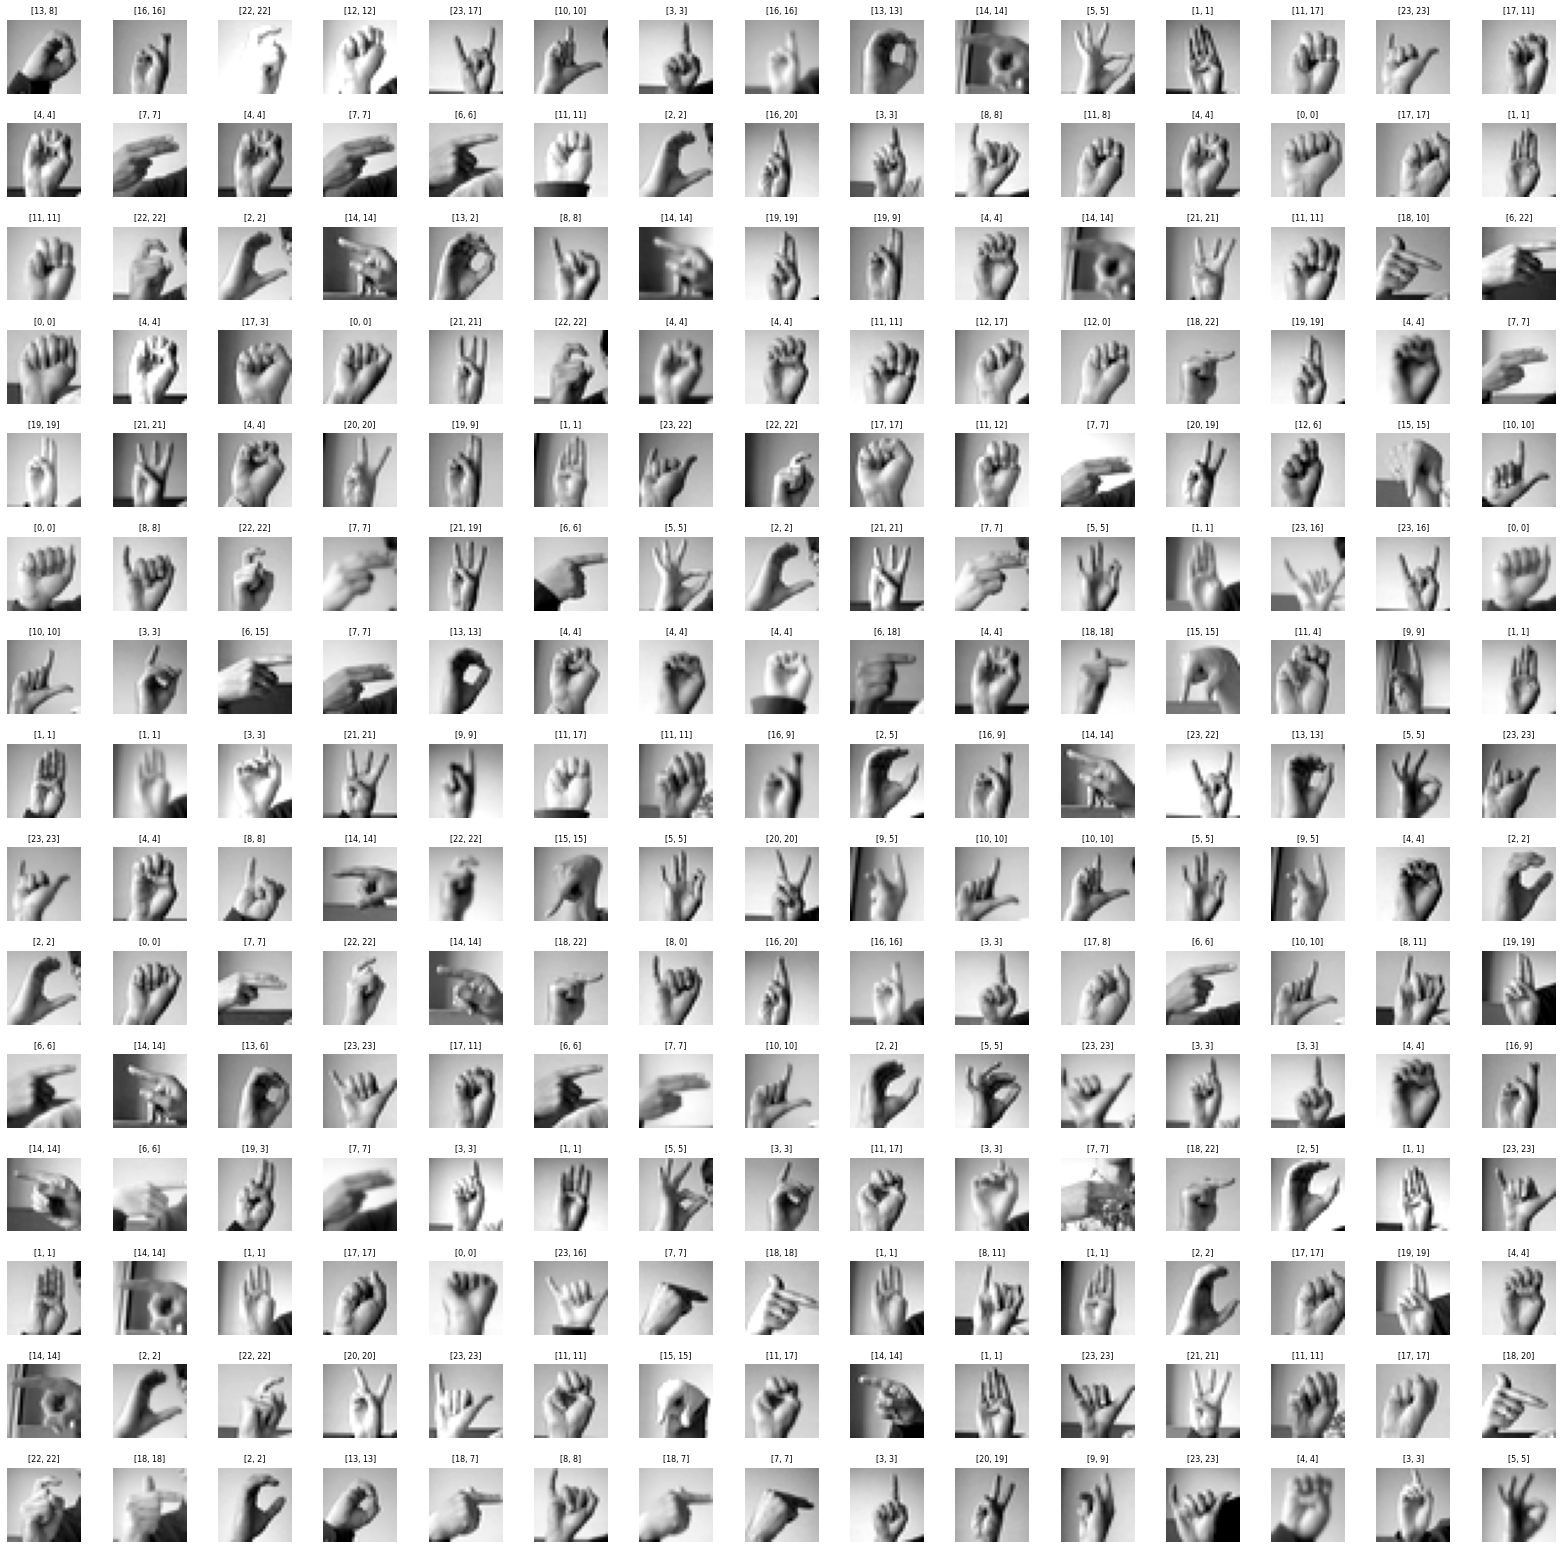

In [ ]:
fig, axes = plt.subplots(L_grid, W_grid, figsize = (28,28))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_test) # get the length of the training dataset

index_mat2 = np.zeros(W_grid * L_grid)

y_pred = np.argmax(best_MLP.predict(X_test), axis=1)

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    index_mat2[i] = index
    axes[i].imshow( X_test.iloc[int(index)].values.reshape(28,28), cmap='gray')
    axes[i].set_title([Y_test[int(index)] , y_pred[int(index)]], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

Las imágenes comparan las etiquetas verdaderas vs (,) las estimadas para un grupo aleatorio de imágenes del grupo de test. Se puede identificar que el modelo da significativamente bien, sin embargo existen algunas clases que pueden mejorar.

## 4. AUTOENCODER + PERCEPTRON MULTICAPA
Se entrena primero una versión rápida de AutoEncoder de referencia.
Algunos criterios para la definición de esta red neuronal:
- Las relaciones entre capas mantienen una relación potencial.
- De forma convencional se selecciona para las neuronas de las capas ocultas una función de activación ReLu.
- Dado que se trata de una tarea de clasificación multiclase se utiliza para la capa de salida una función de activación sigmoide.


In [ ]:
autoencoder = Sequential(name="Autoencoder")

#Capa de Entrada
autoencoder.add(Input(shape=(X_train.shape[1]), name='Input_Layer'))

#Encoder
autoencoder.add(Dense(512, activation='relu', name='Encoder_1'))
autoencoder.add(Dense(256, activation='relu', name='Encoder_2'))
autoencoder.add(Dense(128, activation='relu', name='Encoder_3'))
autoencoder.add(Dense(64, activation='relu', name='Encoder_4'))

#Decoder
autoencoder.add(Dense(128, activation='relu', name='Decoder_4'))
autoencoder.add(Dense(256, activation='relu', name='Decoder_3'))
autoencoder.add(Dense(512, activation='relu', name='Decoder_2'))
autoencoder.add(Dense(X_train.shape[1], activation='softmax', name='Decoder_1'))

Por otra parte:
- Se selecciona como optimizador inicial ADAM, correspondiente a Descenso por el gradiente estocástico, por ser altamente recomendado para este tipo de tareas.
- Como se trata de un problema de clasificación multiclase se define como error la Entropía Cruzada.

In [ ]:
autoencoder.compile(optimizer='adam', loss='binary_crossentropy')
autoencoder.summary()

Model: "Autoencoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder_1 (Dense)           (None, 512)               401920    
                                                                 
 Encoder_2 (Dense)           (None, 256)               131328    
                                                                 
 Encoder_3 (Dense)           (None, 128)               32896     
                                                                 
 Encoder_4 (Dense)           (None, 64)                8256      
                                                                 
 Decoder_4 (Dense)           (None, 128)               8320      
                                                                 
 Decoder_3 (Dense)           (None, 256)               33024     
                                                                 
 Decoder_2 (Dense)           (None, 512)               

Definición de callbacks iniciales:
- Early stopping: con paciencia de 4, asociado a las variables de error "loss" definidas.
- Checkpoints y TensorBoard permiten ven los resultados de las iteraciones.

In [ ]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=4),
    tf.keras.callbacks.ModelCheckpoint(filepath='model.{epoch:02d}-{val_loss:.2f}.h5'),
    tf.keras.callbacks.TensorBoard(log_dir='/content/logs'),
]

Entrenamiento:

In [ ]:
autoencoder.fit(X_Train, X_Train, 
                epochs=50, 
                batch_size=200, 
                callbacks=my_callbacks,
                validation_data=( X_Val, X_Val )
                )

Epoch 1/50
110/110 [==============================] - 2s 8ms/step - loss: 0.6399 - val_loss: 0.6223
Epoch 2/50
110/110 [==============================] - 1s 6ms/step - loss: 0.6181 - val_loss: 0.6107
Epoch 3/50
110/110 [==============================] - 1s 7ms/step - loss: 0.6094 - val_loss: 0.6050
Epoch 4/50
110/110 [==============================] - 1s 7ms/step - loss: 0.6052 - val_loss: 0.6025
Epoch 5/50
110/110 [==============================] - 1s 7ms/step - loss: 0.6025 - val_loss: 0.6000
Epoch 6/50
110/110 [==============================] - 1s 6ms/step - loss: 0.6005 - val_loss: 0.5986
Epoch 7/50
110/110 [==============================] - 1s 6ms/step - loss: 0.5987 - val_loss: 0.5975
Epoch 8/50
110/110 [==============================] - 1s 7ms/step - loss: 0.5977 - val_loss: 0.5964
Epoch 9/50
110/110 [==============================] - 1s 6ms/step - loss: 0.5965 - val_loss: 0.5946
Epoch 10/50
110/110 [==============================] - 1s 6ms/step - loss: 0.5958 - val_loss: 0.5941

Revisión de resultados: Predicción de imágenes y comparación de imágenes originales y reconstruidas.

In [ ]:
predicted = autoencoder.predict(X_Val[:10], batch_size=1)
predicted[0].shape

(784,)

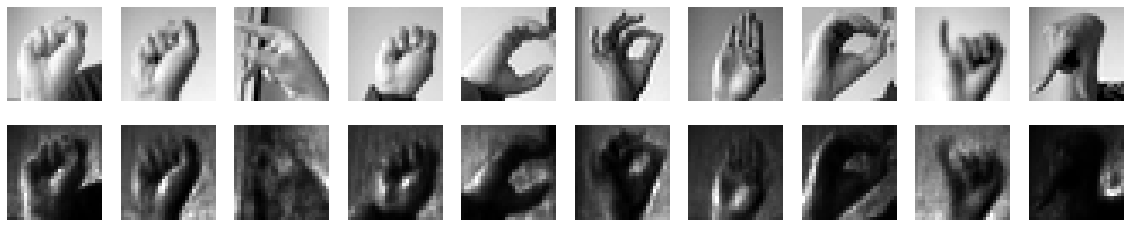

In [ ]:
nCols = 10
fig, axes = plt.subplots(nrows=2, ncols=nCols, sharex=True, sharey=True, figsize=(20,4))
axes = axes.ravel() # flaten axes array

for i in range(nCols):
    axes[i].imshow( X_Val.iloc[i].values.reshape(28,28), cmap='gray')
    axes[i].axis('off')

    axes[i+(nCols)].imshow( predicted[i].reshape(28,28), cmap='gray')
    axes[i+(nCols)].axis('off') 

Se plantean, además, la revisión de otras alternativas buscándo hiperparámetros.

Como hiperparámetros de búsqueda se tienen:
- Número de neuronas.
- Número de capas.
- Optimizador.
- Se usa como pérdida Binary_Crossentropy dado que los valores de salida están entre el rango de [0-1] a pesar que también se podría usar MSE.
- En últimas un encoder estima el valor de los pixeles  de 0  - 1, así que se optimiza entre salidas softmax y lineal.

In [76]:
def entrenarEncoder(hp):
    ENC = Sequential(name='Red_BestEncoder')
    n_layers_ENC = hp.Choice('n_layers_ENC', [2, 3, 4])
    neuronas_ENC = hp.Choice('neuronas_ENC', ['[512, 256, 128 , 64]','[600, 400, 200 , 100]', '[700,300,150,100]'])
    optimizer_ENC = hp.Choice('Optimizer_ENC',['adam','sgd'])
    salida_ENC = hp.Choice( 'Salida_ENC' , ['softmax','linear'] )
    
    # display('-')
    # Convierte string a vector
    neuronas_ENC = eval(neuronas_ENC)

    # Neurona de entrada
    ENC.add(Input(shape=(X_Train.shape[1]),batch_size=None,name='Input_Layer'))
    
    # Neuronas ocultas - Encoder
    Neur_Enc = neuronas_ENC[-n_layers_ENC:-1]
    # display(Neur_Enc)
    for i in range(n_layers_ENC-1):
      # display(i)
      # display(Neur_Enc[i])
      ENC.add(Dense(Neur_Enc[i], activation='relu', name='Capa_Encoder_{0}'.format(i)))

    # Neurona central
    ENC.add(Dense(neuronas_ENC[-1], activation='relu', name='Capa_EncoderMid_{0}'.format(i)))

    # Neuronas ocultas - Decoder
    for i in range(n_layers_ENC-1):
      # display(i)
      # display(Neur_Enc[-i-1])
      ENC.add(Dense(Neur_Enc[-i-1], activation='relu', name='Capa_Decoder_{0}'.format(i)))

    # Capa de salida
    ENC.add(Dense( (X_Train.shape[1]) , activation=salida_ENC, name= 'Capa_Respuesta'))

    ENC.compile(loss='binary_crossentropy',
                optimizer=optimizer_ENC)
       
    ENC.summary()
    
    return ENC

tuner = kt.RandomSearch(
    entrenarEncoder,
    objective="val_loss",
    project_name="Encoder3",
    seed=123,
    max_trials=20)

Model: "Red_BestEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Encoder_0 (Dense)      (None, 128)               100480    
                                                                 
 Capa_EncoderMid_0 (Dense)   (None, 64)                8256      
                                                                 
 Capa_Decoder_0 (Dense)      (None, 128)               8320      
                                                                 
 Capa_Respuesta (Dense)      (None, 784)               101136    
                                                                 
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [77]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

In [78]:
tuner.search(X_Train, X_Train, 
             validation_data=(X_Val, X_Val),
             callbacks=my_callbacks,
             epochs=30)

Trial 14 Complete [00h 01m 03s]
val_loss: 0.6136844158172607

Best val_loss So Far: 0.5823675394058228
Total elapsed time: 00h 18m 02s


In [79]:
best_model = tuner.get_best_models()[0]
best_model.save('best_model_Encoder.h5')
best_model.summary()

Model: "Red_BestEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Encoder_0 (Dense)      (None, 700)               549500    
                                                                 
 Capa_Encoder_1 (Dense)      (None, 300)               210300    
                                                                 
 Capa_Encoder_2 (Dense)      (None, 150)               45150     
                                                                 
 Capa_EncoderMid_2 (Dense)   (None, 100)               15100     
                                                                 
 Capa_Decoder_0 (Dense)      (None, 150)               15150     
                                                                 
 Capa_Decoder_1 (Dense)      (None, 300)               45300     
                                                                 
 Capa_Decoder_2 (Dense)      (None, 700)           

In [80]:
autoencoder = best_model

Ahora, se plantea la adición a las capas del Encoder de un MLP.
Primero se retiran las capas de decoder

In [81]:
encoder = Sequential(name='Encoder')

for layers in autoencoder.layers:
    if "Decoder" in layers.name:
        break
    print(layers.name)
    layers.trainable = False
    encoder.add(layers)

Capa_Encoder_0
Capa_Encoder_1
Capa_Encoder_2
Capa_EncoderMid_2


Se plantean, además, la revisión de otras alternativas buscándo hiperparámetros.

Como hiperparámetros de búsqueda se tienen:
- Número de neuronas.
- Número de capas.
- Optimizador.
- Como se está usando la variable de clases como una única clase categórica se usa como pérdida SPARSE CATEGORICAL CROSSENTROPY de acuerdo con la documentación de Keras (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
- Por el problema se requiere que la capa de salida sea softmax de modo que no se optimiza.

In [84]:
def entrenarRed_ENC_MLP(hp):
    clf = Sequential(name='Red_ENCMLP_Encontrada')
    output = len( label_encoder.classes_ )
    
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[50, 50, 50]','[80, 60, 40]','[80, 80, 50]'])
    optimizer_MLP = hp.Choice('Optimizer_MLP',['adam','sgd'])
    dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    
    neuronas_MLP = eval(neuronas_MLP)

    # Capa de entrada
    clf.add(Input(shape=(X_train.shape[1]),batch_size=None,name='Input_Layer'))
    
    # Capas de encoder
    clf.add(encoder)

    # Capas de MLP-Ocultas
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='relu', name='Capa_Oculta_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    # Capa de salida
    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_MLP,
                metrics=['accuracy'])

    clf.summary()
    
    return clf

tuner = kt.RandomSearch(
    entrenarRed_ENC_MLP,
    objective="val_accuracy",
    project_name="Encoder_MLP2",
    seed=123,
    max_trials=10)

Model: "Red_ENCMLP_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 100)               820050    
                                                                 
 Capa_Oculta_0 (Dense)       (None, 50)                5050      
                                                                 
 Dropout_0.1_0 (Dropout)     (None, 50)                0         
                                                                 
 Capa_Respuesta (Dense)      (None, 24)                1224      
                                                                 
Total params: 826,324
Trainable params: 6,274
Non-trainable params: 820,050
_________________________________________________________________


In [85]:
my_callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=3)
]

Entrenamiento y búsqueda de hiperparámetros.

In [86]:
tuner.search(X_Train, Y_Train, 
             validation_data=(X_Val, Y_Val),
             callbacks=my_callbacks,
             epochs=30)

Trial 10 Complete [00h 01m 15s]
val_accuracy: 0.9908941984176636

Best val_accuracy So Far: 1.0
Total elapsed time: 00h 13m 32s


Revisión del rendimiento del mejor modelo.

In [87]:
best_model = tuner.get_best_models()[0]
best_model.save('best_model_ENCMLP.h5')
best_model.summary()

Model: "Red_ENCMLP_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 100)               820050    
                                                                 
 Capa_Oculta_0 (Dense)       (None, 80)                8080      
                                                                 
 Dropout_0.1_0 (Dropout)     (None, 80)                0         
                                                                 
 Capa_Oculta_1 (Dense)       (None, 80)                6480      
                                                                 
 Dropout_0.1_1 (Dropout)     (None, 80)                0         
                                                                 
 Capa_Oculta_2 (Dense)       (None, 50)                4050      
                                                                 
 Dropout_0.1_2 (Dropout)     (None, 50)      

In [88]:
best_ENCMLP = best_model
y_pred = np.argmax(best_ENCMLP.predict(X_test), axis=1)

print(classification_report(y_true=Y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.89      1.00      0.94       331
           1       0.87      0.95      0.91       432
           2       0.80      0.99      0.89       310
           3       0.72      0.76      0.74       245
           4       0.83      0.95      0.89       498
           5       0.71      0.91      0.80       247
           6       0.93      0.74      0.82       348
           7       0.91      0.95      0.93       436
           8       0.93      0.91      0.92       288
           9       0.55      0.56      0.55       331
          10       0.91      1.00      0.95       209
          11       0.63      0.40      0.49       394
          12       0.66      0.54      0.59       291
          13       0.90      0.67      0.76       246
          14       0.96      1.00      0.98       347
          15       0.99      1.00      1.00       164
          16       0.38      0.76      0.51       144
          17       0.64    

Ejemplificación de algunos resultados del mejor modelo obtenido.

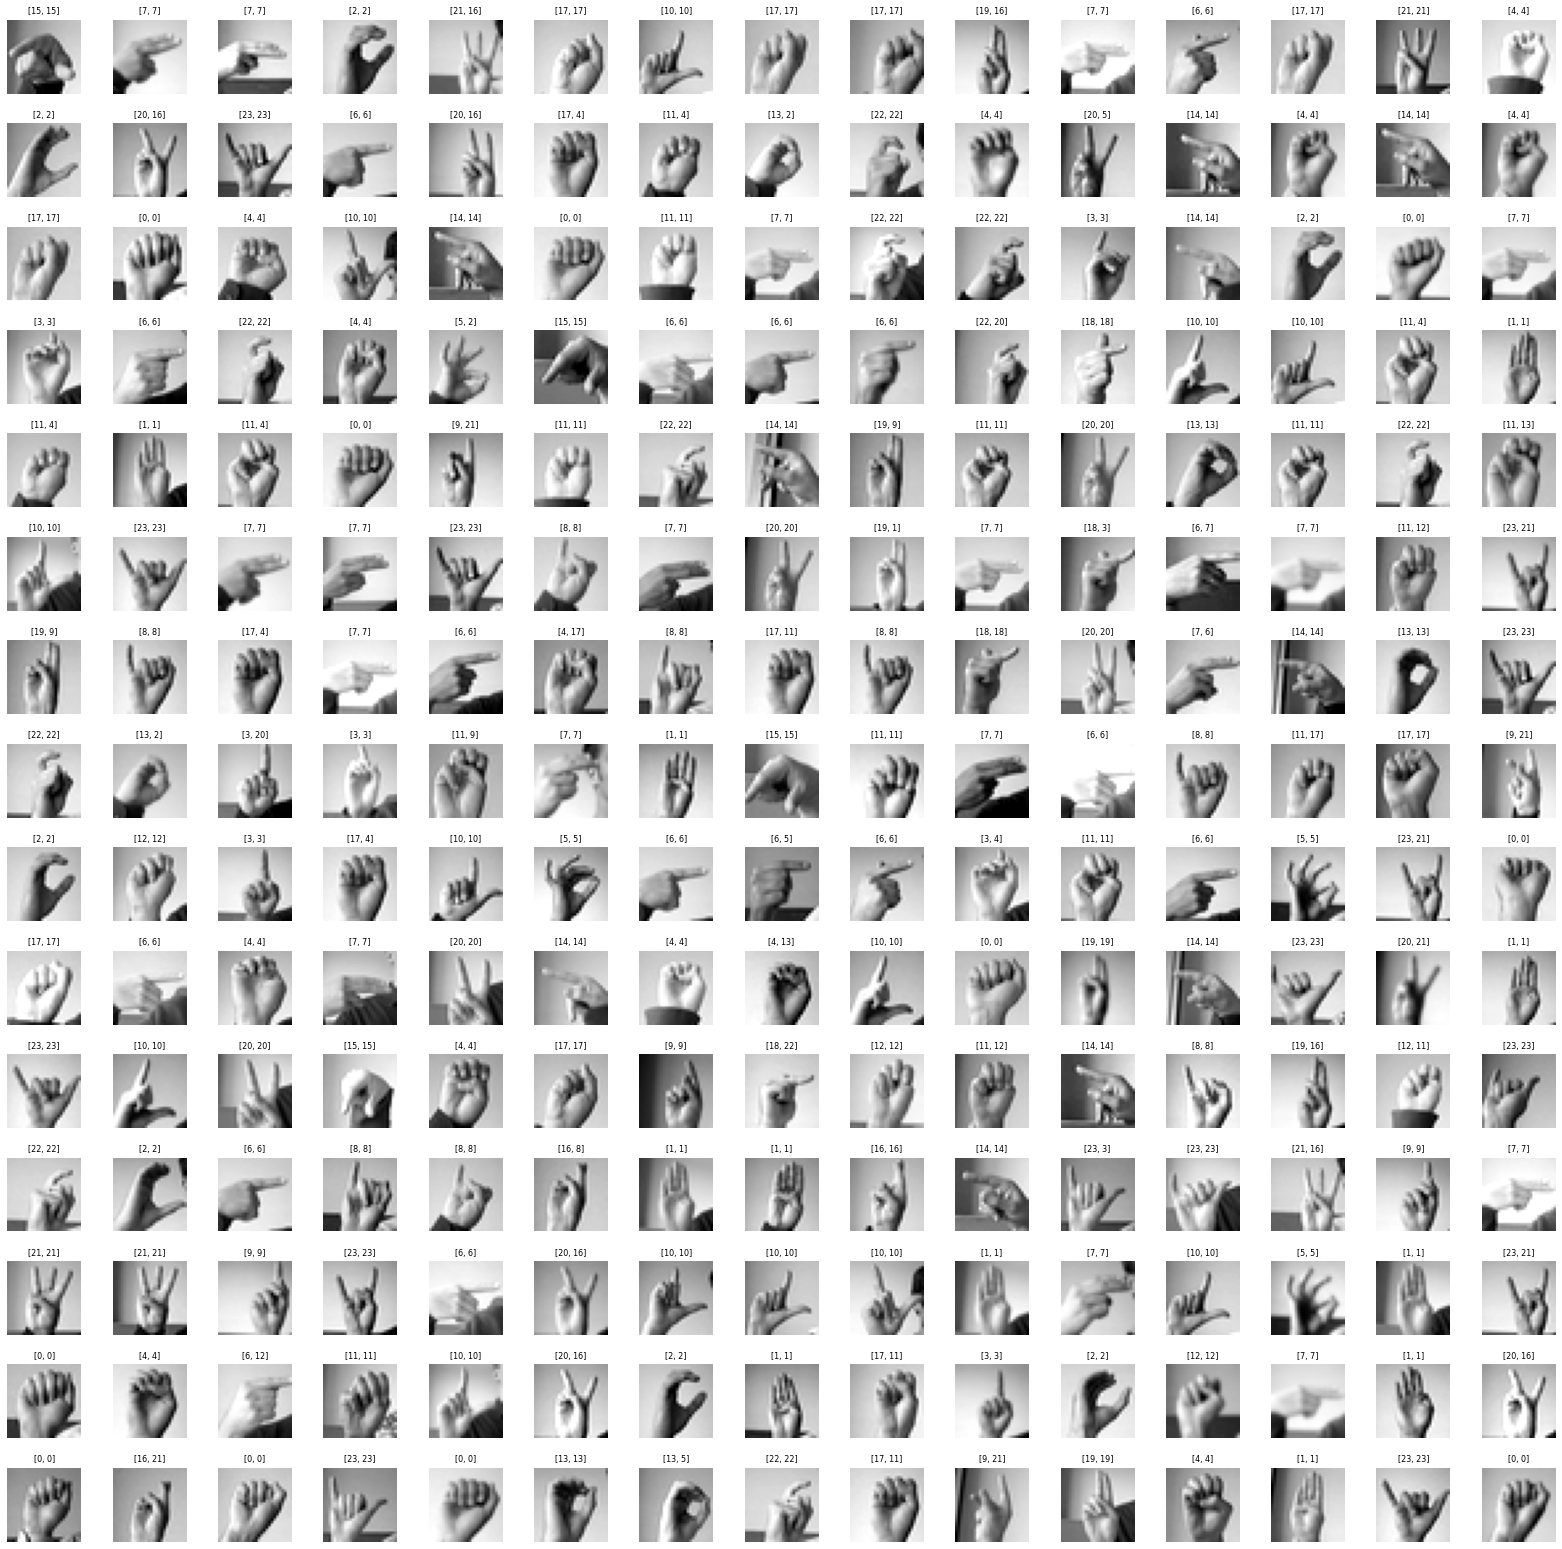

In [89]:
fig, axes = plt.subplots(L_grid, W_grid, figsize = (28,28))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_test) # get the length of the training dataset

y_pred = np.argmax(best_ENCMLP.predict(X_test), axis=1)
index_mat2 = np.zeros(W_grid * L_grid)

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    index_mat2[i] = index
    axes[i].imshow( X_test.iloc[int(index)].values.reshape(28,28), cmap='gray')
    axes[i].set_title([Y_test[int(index)] , y_pred[int(index)]], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

De los resultados anteriores, se puede evidenciar un rendimiento muy similar con respecto a los resultados originales del MLP inicial. Sin embargo, revisando los resultados individuales se encontró que el Encoder+MLP si logra balancear mejor los rendimientos de las clases, mejorando para aquellas en los que el MLP original se encontró deficiente.

## 5. DENOISING AUTOENCODER + PERCEPTRON MULTICAPA
Se repite el ejecicio anterior, ahora, entrenando un DENOISING AUTOENCODER. 
- Para hacerlo, primero se le agrega ruido a las BD originales.

In [ ]:
# Se afecta con un valor de noising arbitrario de 0.2
noise_factor = 0.1

# Se agrega ruido con una distribución normal de valores de [0,1] que es el rango dentro del 
# cual tienen los datos originales
X_TrainDN = X_Train + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Train.shape) 
X_ValDN = X_Val + noise_factor * np.random.normal(loc=0.0, scale=1.0, size=X_Val.shape) 

# Se corrigen los valores superiores a 1 e inferiores a 0
X_TrainDN = np.clip(X_TrainDN, 0., 1.)
X_ValDN = np.clip(X_ValDN, 0., 1.)

display( X_Train.head() ) 

display( X_TrainDN.head() )

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
25906  0.258824  0.294118  0.372549  0.443137  0.486275  0.509804  0.556863   
8678   0.576471  0.580392  0.580392  0.584314  0.584314  0.588235  0.588235   
3784   0.654902  0.658824  0.658824  0.658824  0.658824  0.662745  0.662745   
24628  0.839216  0.847059  0.850980  0.874510  0.803922  0.682353  0.682353   
10141  0.592157  0.615686  0.631373  0.639216  0.647059  0.654902  0.666667   

         pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  \
25906  0.588235  0.607843  0.627451  ...  0.474510  0.211765  0.058824   
8678   0.596078  0.596078  0.596078  ...  0.815686  0.811765  0.811765   
3784   0.662745  0.662745  0.658824  ...  0.611765  0.658824  0.517647   
24628  0.745098  0.400000  0.466667  ...  0.509804  0.509804  0.505882   
10141  0.674510  0.682353  0.694118  ...  0.384314  0.509804  0.847059   

       pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
25906  0.062745  0.133333  0.145098  0.000000  0.090196  0.160784  0.109804  
8678   0.807843  0.800000  0.796078  0.792157  0.792157  0.788235  0.784314  
3784   0.505882  0.619608  0.662745  0.725490  0.694118  0.658824  0.662745  
24628  0.505882  0.513725  0.474510  0.647059  0.474510  0.062745  0.537255  
10141  0.819608  0.823529  0.815686  0.815686  0.815686  0.811765  0.807843  

[5 rows x 784 columns]

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
25906  0.275360  0.234441  0.265975  0.398097  0.709967  0.440853  0.444565   
8678   0.622619  0.616942  0.504238  0.642423  0.492961  0.816239  0.688825   
3784   0.715538  0.733406  0.760672  0.714988  0.447411  0.535988  0.518643   
24628  0.838713  0.834629  0.814810  0.939717  0.911181  0.515760  0.766781   
10141  0.455119  0.640760  0.722829  0.666183  0.519331  0.683289  1.000000   

         pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  \
25906  0.609358  0.623427  0.516163  ...  0.514082  0.269164  0.016750   
8678   0.580833  0.629126  0.578061  ...  0.994352  0.709370  0.802234   
3784   0.591485  0.568211  0.639119  ...  0.640148  0.637679  0.522882   
24628  0.816164  0.321304  0.639723  ...  0.654134  0.459735  0.583567   
10141  0.632328  0.650585  0.818900  ...  0.523077  0.356608  0.780869   

       pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
25906  0.000000  0.275840  0.181611  0.000000  0.097868  0.296075  0.072345  
8678   0.739067  0.854357  0.965142  0.815233  0.685913  0.775217  0.856943  
3784   0.370692  0.687664  0.713060  0.621639  0.438223  0.657075  0.609715  
24628  0.410068  0.375597  0.493862  0.595164  0.757496  0.016096  0.270183  
10141  0.739530  0.752796  0.790525  0.786389  0.691090  0.825827  0.925247  

[5 rows x 784 columns]

Visualización de algunas imágenes:

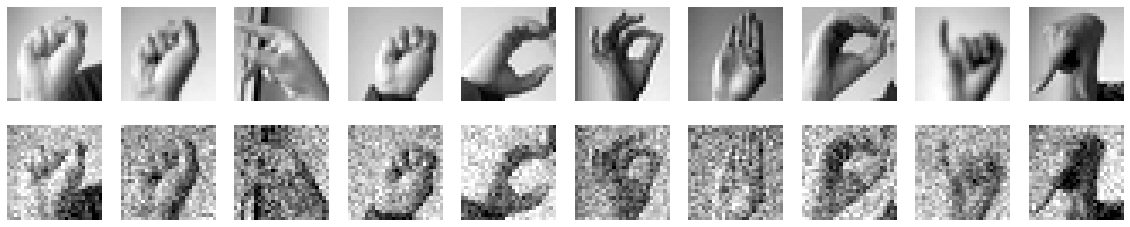

In [ ]:
nCols = 10
fig, axes = plt.subplots(nrows=2, ncols=nCols, sharex=True, sharey=True, figsize=(20,4))
axes = axes.ravel() # flaten axes array

for i in range(nCols):
    axes[i].imshow( X_Val.iloc[i].values.reshape(28,28), cmap='gray')
    axes[i].axis('off')

    axes[i+(nCols)].imshow( X_ValDN.iloc[i].values.reshape(28,28), cmap='gray')
    axes[i+(nCols)].axis('off') 

Se plantean, además, la revisión de alternativas buscándo hiperparámetros.

Como hiperparámetros de búsqueda se tienen:
- Número de neuronas.
- Número de capas.
- Optimizador.
- Se usa como pérdida Binary_Crossentropy dado que los valores de salida están entre el rango de [0-1] a pesar que también se podría usar MSE.
- En últimas un encoder estima el valor de los pixeles  de 0  - 1, así que se optimiza entre salidas softmax y lineal.

In [90]:
def entrenarEncoderDN(hp):
    ENC = Sequential(name='Red_BestEncoder')
    n_layers_ENC = hp.Choice('n_layers_ENC', [2, 3, 4])
    neuronas_ENC = hp.Choice('neuronas_ENC', ['[512, 256, 128 , 64]','[600, 400, 200 , 100]', '[600,300,150,100]'])
    optimizer_ENC = hp.Choice('Optimizer_ENC',['adam','sgd'])
    salida_ENC = hp.Choice( 'Salida_ENC' , ['softmax','linear'] )
    
    # display('-')
    # Convierte string a vector
    neuronas_ENC = eval(neuronas_ENC)

    # Neurona de entrada
    ENC.add(Input(shape=(X_Train.shape[1]),batch_size=None,name='Input_Layer'))
    
    # Neuronas ocultas - Encoder
    Neur_Enc = neuronas_ENC[-n_layers_ENC:-1]
    # display(Neur_Enc)
    for i in range(n_layers_ENC-1):
      # display(i)
      # display(Neur_Enc[i])
      ENC.add(Dense(Neur_Enc[i], activation='relu', name='Capa_Encoder_{0}'.format(i)))

    # Neurona central
    ENC.add(Dense(neuronas_ENC[-1], activation='relu', name='Capa_EncoderMid_{0}'.format(i)))

    # Neuronas ocultas - Decoder
    for i in range(n_layers_ENC-1):
      # display(i)
      # display(Neur_Enc[-i-1])
      ENC.add(Dense(Neur_Enc[-i-1], activation='relu', name='Capa_Decoder_{0}'.format(i)))

    # Capa de salida
    ENC.add(Dense( (X_Train.shape[1]) , activation=salida_ENC, name= 'Capa_Respuesta'))

    ENC.compile(loss='binary_crossentropy',
                optimizer=optimizer_ENC)
       
    ENC.summary()
    
    return ENC

tuner = kt.RandomSearch(
    entrenarEncoderDN,
    objective="val_loss",
    project_name="EncoderDN2",
    seed=123,
    max_trials=20)

Model: "Red_BestEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Encoder_0 (Dense)      (None, 128)               100480    
                                                                 
 Capa_EncoderMid_0 (Dense)   (None, 64)                8256      
                                                                 
 Capa_Decoder_0 (Dense)      (None, 128)               8320      
                                                                 
 Capa_Respuesta (Dense)      (None, 784)               101136    
                                                                 
Total params: 218,192
Trainable params: 218,192
Non-trainable params: 0
_________________________________________________________________


In [91]:
tuner.search(X_TrainDN, X_Train, 
             validation_data=(X_ValDN, X_Val),
             callbacks=my_callbacks,
             epochs=30)

Trial 14 Complete [00h 00m 39s]
val_loss: 0.6415444612503052

Best val_loss So Far: 0.5836272835731506
Total elapsed time: 00h 17m 15s


Mejor modelo:

In [92]:
best_model = tuner.get_best_models()[0]
best_model.save('best_model_DNEncoder.h5')
DNAutoencoder = best_model

Model: "Red_BestEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Encoder_0 (Dense)      (None, 600)               471000    
                                                                 
 Capa_Encoder_1 (Dense)      (None, 300)               180300    
                                                                 
 Capa_Encoder_2 (Dense)      (None, 150)               45150     
                                                                 
 Capa_EncoderMid_2 (Dense)   (None, 100)               15100     
                                                                 
 Capa_Decoder_0 (Dense)      (None, 150)               15150     
                                                                 
 Capa_Decoder_1 (Dense)      (None, 300)               45300     
                                                                 
 Capa_Decoder_2 (Dense)      (None, 600)           

In [93]:
DNAutoencoder.summary()
DNAutoencoder.save('best_model_DNEncoder.h5')

Model: "Red_BestEncoder"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Capa_Encoder_0 (Dense)      (None, 600)               471000    
                                                                 
 Capa_Encoder_1 (Dense)      (None, 300)               180300    
                                                                 
 Capa_Encoder_2 (Dense)      (None, 150)               45150     
                                                                 
 Capa_EncoderMid_2 (Dense)   (None, 100)               15100     
                                                                 
 Capa_Decoder_0 (Dense)      (None, 150)               15150     
                                                                 
 Capa_Decoder_1 (Dense)      (None, 300)               45300     
                                                                 
 Capa_Decoder_2 (Dense)      (None, 600)           

A continuación, se realiza una prueba de los resultados el autoencoder encontrado.

In [94]:
predicted = DNAutoencoder.predict(X_ValDN[:10], batch_size=1)
predicted[0].shape

(784,)

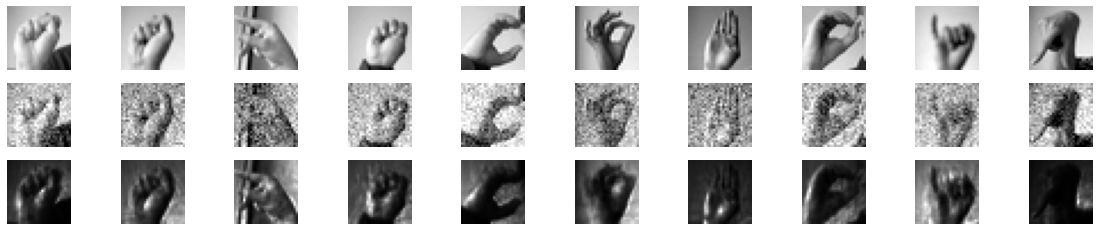

In [95]:
nCols = 10
fig, axes = plt.subplots(nrows=3, ncols=nCols, sharex=True, sharey=True, figsize=(20,4))
axes = axes.ravel() # flaten axes array

for i in range(nCols):
    axes[i].imshow( X_Val.iloc[i].values.reshape(28,28), cmap='gray')
    axes[i].axis('off')

    axes[i+(nCols)].imshow( X_ValDN.iloc[i].values.reshape(28,28), cmap='gray')
    axes[i+(nCols)].axis('off') 

    axes[i+(nCols)*2].imshow( predicted[i].reshape(28,28), cmap='gray')
    axes[i+(nCols)*2].axis('off') 


Ahora, se adiciona el MPL y se entrena solo con el 10% de los datos de la BD original de entrenamiento.

In [96]:
encoderDN = Sequential(name='Encoder')

for layers in DNAutoencoder.layers:
    if "Decoder" in layers.name:
        break
    print(layers.name)
    layers.trainable = False
    encoderDN.add(layers)

Capa_Encoder_0
Capa_Encoder_1
Capa_Encoder_2
Capa_EncoderMid_2


Se plantean, además, la revisión de alternativas buscándo hiperparámetros.

Como hiperparámetros de búsqueda se tienen:
- Número de neuronas.
- Número de capas.
- Optimizador.
- Como se está usando la variable de clases como una única clase categórica se usa como pérdida SPARSE CATEGORICAL CROSSENTROPY de acuerdo con la documentación de Keras (https://www.tensorflow.org/api_docs/python/tf/keras/losses/SparseCategoricalCrossentropy)
- Por el problema se requiere que la capa de salida sea softmax de modo que no se optimiza.

In [99]:
def entrenarRed_DNENC_MLP(hp):
    clf = Sequential(name='Red_ENCMLP_Encontrada')
    output = len( label_encoder.classes_ )
    
    n_layers_MLP = hp.Choice('n_layers_MLP', [1, 2, 3])
    neuronas_MLP = hp.Choice('neuronas_MLP', ['[90, 70, 40]','[90, 80, 50]','[80, 80, 80]'])
    optimizer_MLP = hp.Choice('Optimizer_MLP',['adam','sgd'])
    dropout = hp.Choice('dropout', [0.1,0.3,0.5])
    
    neuronas_MLP = eval(neuronas_MLP)

    # Capa de entrada
    clf.add(Input(shape=(X_train.shape[1]),batch_size=None,name='Input_Layer'))
    
    # Capas de encoder
    clf.add(encoderDN)

    # Capas de MLP-Ocultas
    for i in range(n_layers_MLP):
        clf.add(Dense(neuronas_MLP[i], activation='relu', name='Capa_Oculta_{0}'.format(i)))
        clf.add(Dropout(dropout,name='Dropout_{0}_{1}'.format(dropout,i)))

    # Capa de salida
    clf.add(Dense(output, activation='softmax', name= 'Capa_Respuesta'))

    clf.compile(loss='sparse_categorical_crossentropy',
                optimizer=optimizer_MLP,
                metrics=['accuracy'])

    clf.summary()
    
    return clf

tuner = kt.RandomSearch(
    entrenarRed_DNENC_MLP,
    objective="val_accuracy",
    project_name="EncoderDN_MLP10_3",
    seed=123,
    max_trials=10)

Model: "Red_ENCMLP_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 100)               711550    
                                                                 
 Capa_Oculta_0 (Dense)       (None, 90)                9090      
                                                                 
 Dropout_0.1_0 (Dropout)     (None, 90)                0         
                                                                 
 Capa_Respuesta (Dense)      (None, 24)                2184      
                                                                 
Total params: 722,824
Trainable params: 11,274
Non-trainable params: 711,550
_________________________________________________________________


Separación del 10% de los datos (10% de la BD de test y 10% de la BD de validación = 10% de la BD de entrenamiento original):

In [ ]:
X_Train10, X_Test10, Y_Train10, Y_Test10 = train_test_split( X_Train , Y_Train, test_size=0.90, random_state=42)
X_Val10, X_Test10_2, Y_Val10, Y_Test10_2 = train_test_split( X_Val , Y_Val, test_size=0.90, random_state=42)
display(X_Train10)
display(X_Val10)

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
12240  0.564706  0.592157  0.607843  0.623529  0.639216  0.650980  0.658824   
24803  0.588235  0.611765  0.639216  0.650980  0.666667  0.682353  0.694118   
17598  0.741176  0.749020  0.756863  0.764706  0.768627  0.764706  0.764706   
24283  0.227451  0.247059  0.270588  0.305882  0.333333  0.356863  0.380392   
23378  0.458824  0.474510  0.494118  0.517647  0.537255  0.556863  0.572549   
...         ...       ...       ...       ...       ...       ...       ...   
9200   0.552941  0.560784  0.572549  0.576471  0.584314  0.592157  0.600000   
648    0.572549  0.580392  0.588235  0.596078  0.603922  0.615686  0.619608   
26516  0.811765  0.819608  0.823529  0.827451  0.827451  0.831373  0.839216   
10558  0.337255  0.341176  0.349020  0.364706  0.407843  0.447059  0.478431   
8521   0.701961  0.701961  0.701961  0.705882  0.705882  0.709804  0.705882   

         pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  \
12240  0.666667  0.674510  0.682353  ...  0.807843  0.811765  0.819608   
24803  0.701961  0.717647  0.717647  ...  0.423529  0.149020  0.317647   
17598  0.764706  0.760784  0.760784  ...  0.654902  0.898039  0.827451   
24283  0.388235  0.403922  0.415686  ...  0.678431  0.690196  0.698039   
23378  0.580392  0.592157  0.600000  ...  0.800000  0.807843  0.811765   
...         ...       ...       ...  ...       ...       ...       ...   
9200   0.600000  0.611765  0.619608  ...  0.000000  0.521569  0.800000   
648    0.627451  0.631373  0.635294  ...  0.380392  0.686275  0.796078   
26516  0.843137  0.843137  0.843137  ...  1.000000  1.000000  1.000000   
10558  0.513725  0.537255  0.549020  ...  0.988235  0.956863  0.933333   
8521   0.705882  0.705882  0.705882  ...  0.270588  0.247059  0.235294   

       pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
12240  0.819608  0.823529  0.819608  0.831373  0.835294  0.835294  0.835294  
24803  0.882353  0.949020  0.929412  0.937255  0.933333  0.933333  0.929412  
17598  0.831373  0.823529  0.811765  0.800000  0.792157  0.776471  0.772549  
24283  0.705882  0.705882  0.705882  0.705882  0.709804  0.713725  0.713725  
23378  0.819608  0.819608  0.819608  0.819608  0.823529  0.823529  0.827451  
...         ...       ...       ...       ...       ...       ...       ...  
9200   0.737255  0.749020  0.745098  0.741176  0.741176  0.733333  0.729412  
648    0.811765  0.815686  0.815686  0.811765  0.811765  0.811765  0.815686  
26516  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  1.000000  
10558  0.949020  0.890196  0.619608  0.352941  0.466667  0.541176  0.501961  
8521   0.207843  0.203922  0.152941  0.164706  0.211765  0.141176  0.168627  

[2196 rows x 784 columns]

pixel1    pixel2    pixel3    pixel4    pixel5    pixel6    pixel7  \
3193   0.615686  0.619608  0.619608  0.623529  0.623529  0.623529  0.623529   
24694  0.258824  0.309804  0.345098  0.364706  0.384314  0.400000  0.411765   
675    0.745098  0.745098  0.745098  0.752941  0.756863  0.760784  0.760784   
7232   0.600000  0.607843  0.615686  0.623529  0.623529  0.631373  0.635294   
10694  0.678431  0.682353  0.690196  0.698039  0.705882  0.705882  0.713725   
...         ...       ...       ...       ...       ...       ...       ...   
25753  0.725490  0.729412  0.729412  0.725490  0.725490  0.729412  0.729412   
20414  0.556863  0.564706  0.576471  0.580392  0.588235  0.596078  0.600000   
3249   0.701961  0.709804  0.713725  0.713725  0.713725  0.717647  0.721569   
5852   0.556863  0.396078  0.713725  0.290196  0.152941  0.407843  0.388235   
1420   0.254902  0.270588  0.333333  0.407843  0.462745  0.486275  0.521569   

         pixel8    pixel9   pixel10  ...  pixel775  pixel776  pixel777  \
3193   0.619608  0.619608  0.615686  ...  0.823529  0.815686  0.807843   
24694  0.423529  0.435294  0.450980  ...  0.647059  0.647059  0.647059   
675    0.752941  0.752941  0.749020  ...  0.000000  0.000000  0.764706   
7232   0.643137  0.650980  0.654902  ...  0.764706  0.764706  0.760784   
10694  0.721569  0.717647  0.725490  ...  0.843137  0.850980  0.847059   
...         ...       ...       ...  ...       ...       ...       ...   
25753  0.729412  0.729412  0.729412  ...  0.878431  0.878431  0.878431   
20414  0.607843  0.611765  0.615686  ...  0.360784  0.729412  0.749020   
3249   0.725490  0.729412  0.729412  ...  0.929412  0.925490  0.921569   
5852   0.403922  0.415686  0.427451  ...  1.000000  0.976471  0.741176   
1420   0.572549  0.603922  0.635294  ...  0.490196  0.388235  0.294118   

       pixel778  pixel779  pixel780  pixel781  pixel782  pixel783  pixel784  
3193   0.796078  0.792157  0.784314  0.780392  0.768627  0.760784  0.749020  
24694  0.658824  0.662745  0.662745  0.662745  0.666667  0.662745  0.662745  
675    0.831373  0.803922  0.803922  0.780392  0.698039  0.705882  0.611765  
7232   0.760784  0.760784  0.764706  0.764706  0.760784  0.760784  0.756863  
10694  0.843137  0.847059  0.839216  0.831373  0.827451  0.827451  0.823529  
...         ...       ...       ...       ...       ...       ...       ...  
25753  0.874510  0.870588  0.870588  0.866667  0.862745  0.866667  0.796078  
20414  0.741176  0.737255  0.741176  0.737255  0.729412  0.729412  0.729412  
3249   0.921569  0.917647  0.909804  0.921569  0.941176  0.941176  0.921569  
5852   0.556863  0.447059  0.501961  0.541176  0.521569  0.525490  0.525490  
1420   0.039216  0.000000  0.062745  0.145098  0.094118  0.027451  0.000000  

[549 rows x 784 columns]

Búsqueda de hiperparámetros:

In [100]:
tuner.search(X_Train10, Y_Train10, 
             validation_data=(X_Val10, Y_Val10),
             callbacks=my_callbacks,
             epochs=30)

Trial 10 Complete [00h 00m 09s]
val_accuracy: 0.8378870487213135

Best val_accuracy So Far: 0.8579235076904297
Total elapsed time: 00h 01m 39s


Se guarda el mejor resultado:

In [101]:
best_model = tuner.get_best_models()[0]
best_model.save('best_model_DNENCMLP.h5')
best_model.summary()

Model: "Red_ENCMLP_Encontrada"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 Encoder (Sequential)        (None, 100)               711550    
                                                                 
 Capa_Oculta_0 (Dense)       (None, 80)                8080      
                                                                 
 Dropout_0.1_0 (Dropout)     (None, 80)                0         
                                                                 
 Capa_Oculta_1 (Dense)       (None, 80)                6480      
                                                                 
 Dropout_0.1_1 (Dropout)     (None, 80)                0         
                                                                 
 Capa_Oculta_2 (Dense)       (None, 80)                6480      
                                                                 
 Dropout_0.1_2 (Dropout)     (None, 80)      

Se calculan los rendimientos de este modelo.

In [102]:
best_DNENCMLP = best_model
y_pred = np.argmax(best_DNENCMLP.predict(X_test), axis=1)

print(classification_report(y_true=Y_test, y_pred=y_pred))

              precision    recall  f1-score   support

           0       0.72      0.89      0.80       331
           1       1.00      0.87      0.93       432
           2       0.75      0.78      0.77       310
           3       0.99      0.71      0.83       245
           4       0.81      0.84      0.83       498
           5       0.73      0.83      0.78       247
           6       0.74      0.79      0.76       348
           7       0.98      0.83      0.90       436
           8       0.69      0.59      0.64       288
           9       0.55      0.60      0.58       331
          10       0.90      0.99      0.94       209
          11       0.51      0.46      0.49       394
          12       0.56      0.53      0.55       291
          13       0.70      0.53      0.60       246
          14       0.94      0.96      0.95       347
          15       0.92      0.82      0.87       164
          16       0.18      0.28      0.22       144
          17       0.37    

A continuación, se muestran algunos ejemplos de clasificación:

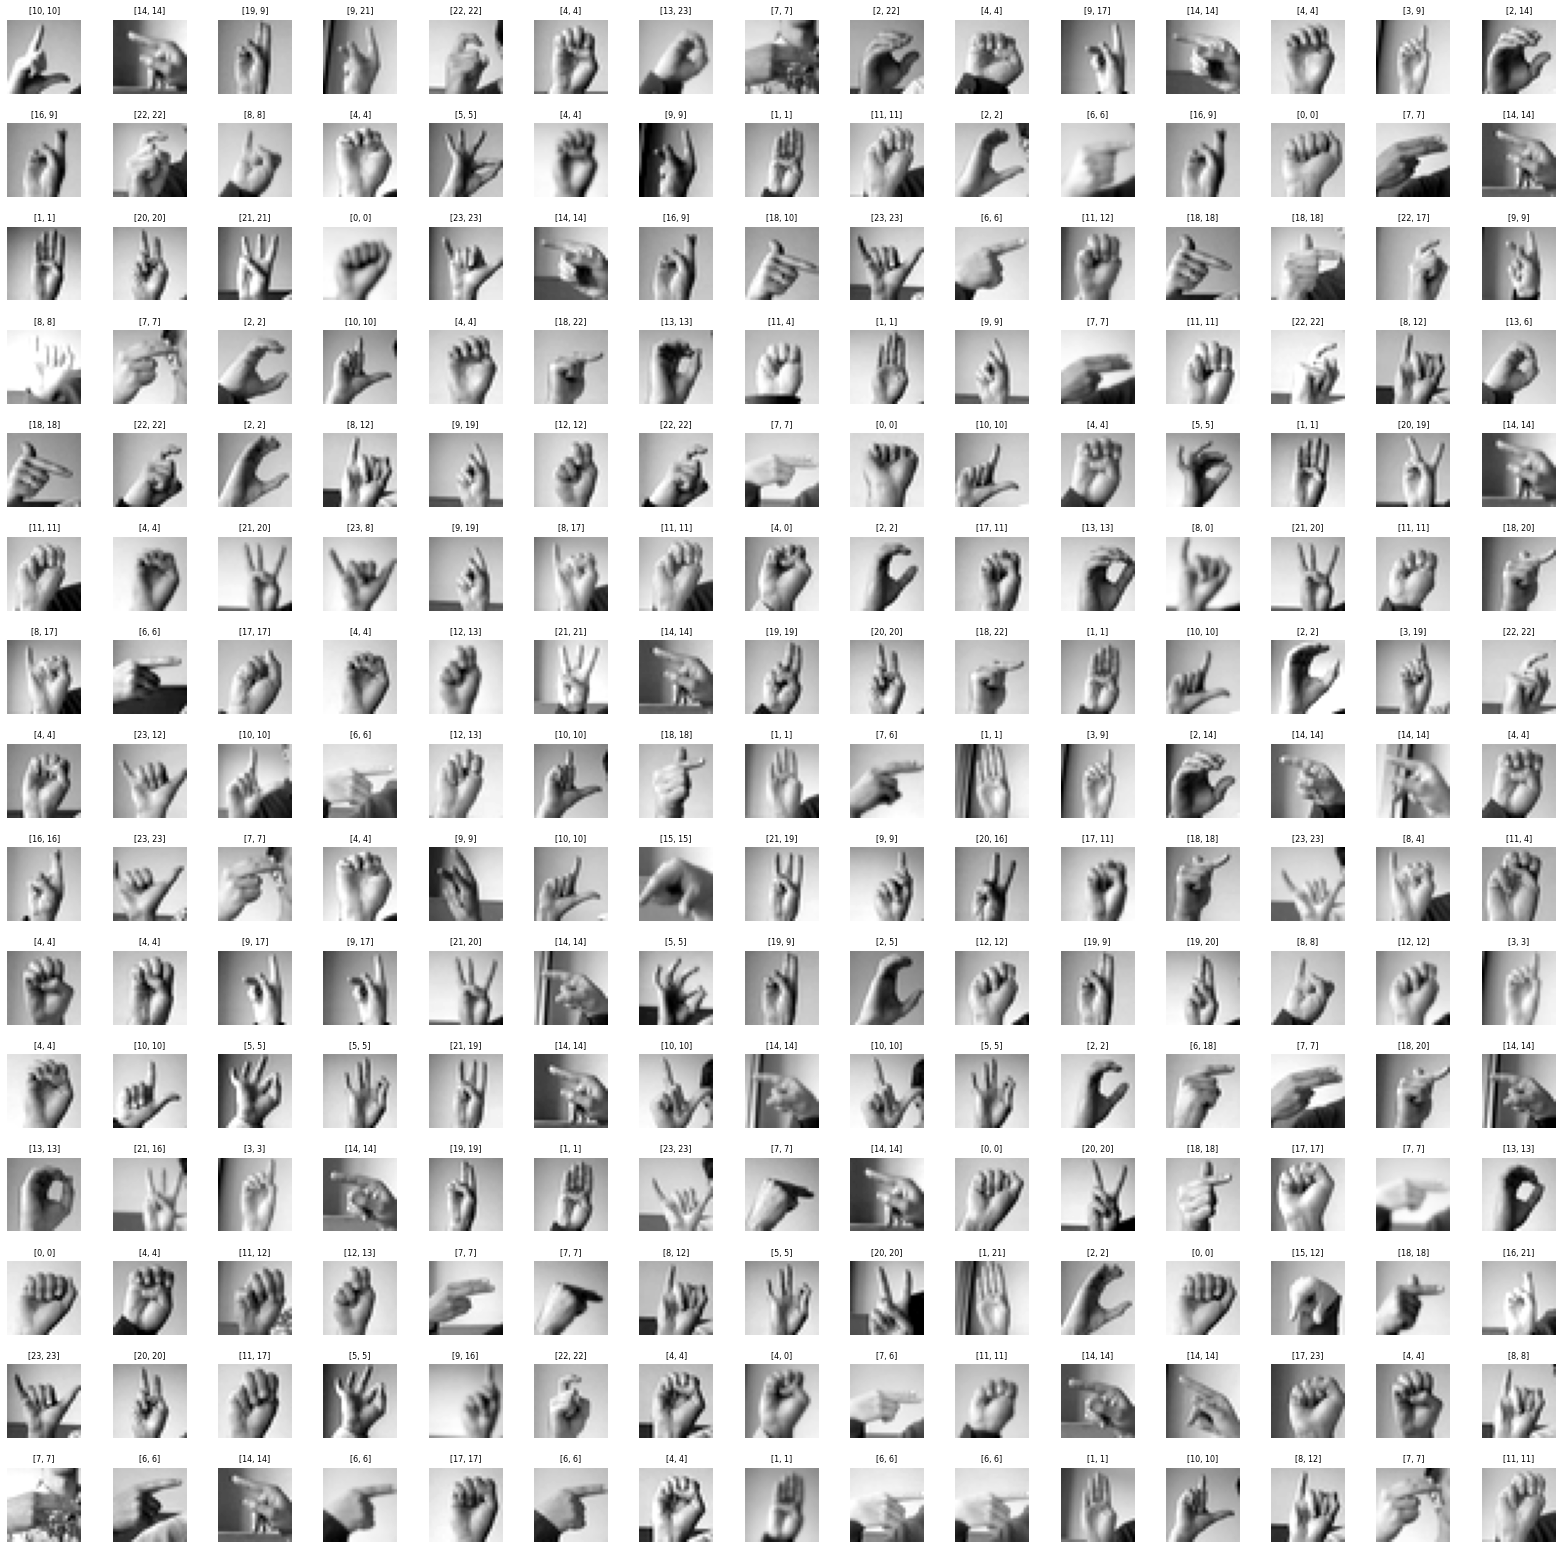

In [103]:
fig, axes = plt.subplots(L_grid, W_grid, figsize = (28,28))
axes = axes.ravel() # flaten the 15 x 15 matrix into 225 array
n_training = len(X_test) # get the length of the training dataset

y_pred = np.argmax(best_DNENCMLP.predict(X_test), axis=1)
index_mat2 = np.zeros(W_grid * L_grid)

# Select a random number from 0 to n_training
for i in np.arange(0, W_grid * L_grid):
    index = np.random.randint(0, n_training)
    index_mat2[i] = index
    axes[i].imshow( X_test.iloc[int(index)].values.reshape(28,28), cmap='gray')
    axes[i].set_title([Y_test[int(index)] , y_pred[int(index)]], fontsize = 8)
    axes[i].axis('off')

plt.subplots_adjust(hspace=0.4)

De las métricas de rendimiento del modelo se puede evidenciar una clara desmejora en el rendimiento asociado al tener una reducción de la base de datos en entrenamiento. Esto se puede observar especialmente que las categorías que presentaron un peor comportamiento en los modelos anteriores, presentan rendimientos mucho más bajos con este modelo. 

No obstante, para las categorías de más altos rendimientos alcanzaron también buenos resultados a pesar de la reducción. De lo anterior se puede sintetizar:
- Las categorías más distinguibles se pueden caracterizar de forma adecuada con un modelo de DN Encoder + MLP a pesar de que se cuente con un número limitado de datos etiquetados.
- Las categorías más dificiles de distinguir entre sí: (N, R, S, U y W) de acuerdo con este ejercicio, requieren un mayor número de datos clasificados.

## 6. COMPARACIÓN DE RESULTADOS Y CONCLUSIONES
A continuación se resumen algunas métricas de los rendimientos  de los tres modelos.


- Con respecto a su precisión:

| Precision\Modelo | MLP | ENC_MLP | DNENC_MLP |
|----|----|----|----|
| Promedio | 0.77 | 0.78 | 0.70 |
| Max | 1.00 | 0.99| 1.00 |
| Min | 0.27 | 0.38 | 0.18 | 

- Con respecto a su recall:

| Recall\Modelo | MLP | ENC_MLP | DNENC_MLP |
|----|----|----|----|
| Promedio | 0.75 | 0.77 | 0.67 |
| Max | 1.00 | 1.00 | 0.99 |
| Min | 0.38 | 0.40 | 0.28 | 

Los tres modelos corresponden a los resultados obtenidos optimizando de acuerdo a su ACCURACY. Se definió que este era el criterio de mayor importancia para que presentara las estimaciones con menores errores posibles tanto de FN como de FP. No se considera que las condiciones del negocio requiera que se favorezcan más o menos algunos tipos de errores (Ej: decisiones conservadoras para problemas de alto riesgo).

De los rendimientos anteriores se puede concluir que:
- Los modelos de MLP (multilayer perceptron) y ENC_MPL (encoder + multilayer perceptron) presentaron rendimientos ponderados muy similares.
- El modelo de peor desempeño promedio fue el DNENC_MPL (denoising encoder + multilayer perceptron)
- El modelo de ENC_MLP presentó a nivel de clases rendimientos más balanceados que el modelo de MLP. De tal forma, que la letra que peor rendimiento tuvo fue de 0.38 (accuracy) y 0.40 (recall), mientras que MPL obtuvo 0.27 y 0.38 respectivamente. De lo anterior, se identifica que la extracción de características sirvió para identificar mejor las diferencias entre las clases más dificiles de clasificar.
- Por otra parte, el modelo DNENC_MLP permite observar que una extracción de características robusta, entrenada con denoising tiene éxito obteniendo los rasgos que distinguen las clases más diferenciables entre si. Sin embargo, para las clases más dificiles de distinguir presenta un peor comportamiento.
- En conclusión, generalizando, dependiendo de la disponibilidad de la información se puede usar encoding o denoising encoding para obtener un modelo de rendimiento general satisfactorio. Sin embargo, para ambos casos, una buena reducción de dimensionalidad y extracción de características es una consideración importante que puede servir al modelo.
- Con respecto a las diferencias entre los resultados de las pruebas de validación y entrenamiento con respecto a los rendimientos del tests, se identifica que los modelos pueden estar un poco sobreajustados. Sin embargo, de las iteraciones realizadas fueron los modelos que mejores rendimientos en test presentaron variando los sets de neuronas mínimas de los encoders y de los MLP.